In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split

from torch.cuda.amp import autocast, GradScaler
torch.cuda.empty_cache()


import importlib
import tools_torch
importlib.reload(tools_torch)
from tools_torch import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda:0


In [4]:
data = np.load("../datasets/godunov_combined_tpast2_tpred8_receding.npz", allow_pickle=True)

# Extract the data
branch_coords = torch.tensor(data['branch_coords'])
branch_values = torch.tensor(data['branch_values'])
output_sensor_coords = torch.tensor(data['output_sensor_coords'])
output_sensor_values = torch.tensor(data['output_sensor_values'])
rho = torch.tensor(data['rho'])
x = torch.tensor(data['x'])
t = torch.tensor(data['t'])
Nx = data['Nx'].item()
Nt = data['Nt'].item()
Xmax = data['Xmax'].item()
Tmax = data['Tmax'].item()
N = data['N'].item()
t_starts = torch.tensor(data['t_starts'])
t_pred = torch.tensor(data['t_pred'])
t_past = torch.tensor(data['t_past'])


print(f"Nx = {Nx}, Nt = {Nt}, Xmax = {Xmax}, Tmax = {Tmax}, N = {N}")
print(f"branch_coords.shape = {branch_coords.shape}, branch_values.shape = {branch_values.shape}, output_sensor_coords.shape = {output_sensor_coords.shape}, ")
print(f"output_sensor_values.shape = {output_sensor_values.shape}, x.shape = {x.shape}, t.shape = {t.shape}")
print(f"t_starts = {t_starts.shape}")
# print(", rho.shape = {rho.shape}")

Nx = 250, Nt = 469, Xmax = 5, Tmax = 25, N = 100
branch_coords.shape = torch.Size([100, 376, 3]), branch_values.shape = torch.Size([100, 376, 2]), output_sensor_coords.shape = torch.Size([100, 2720, 2]), 
output_sensor_values.shape = torch.Size([100, 2720]), x.shape = torch.Size([100, 250]), t.shape = torch.Size([100, 469])
t_starts = torch.Size([100])


In [5]:
# set numpy random seed
np.random.seed(42)

# Define the validation percentage
validation_percentage = 0.2  # validation

branch_coords_train, branch_coords_val, branch_values_train, branch_values_val, \
output_sensor_coords_train, output_sensor_coords_val, output_sensor_values_train, output_sensor_values_val, rho_train, rho_val, \
t_starts_train, t_starts_val = train_test_split(
    branch_coords, branch_values, output_sensor_coords, output_sensor_values, rho, t_starts,
    test_size=validation_percentage, random_state=42
)

In [6]:
# Create dataset and dataloader
batch_size = 32
train_dataset = DeepONetDatasetTrain(branch_coords_train[:,:,:], branch_values_train[:,:,0:1], output_sensor_coords_train, output_sensor_values_train, device=device) # branch_coord, branch_values, trunk_coords, targets, UU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataset = DeepONetDatasetTrain(branch_coords_val[:,:,:], branch_values_val[:,:,0:1], output_sensor_coords_val, output_sensor_values_val, device=device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

xs, us, ys, ss = next(iter(train_loader))
print(f"train shapes\t xs: {xs.shape}, us: {us.shape}, ys: {ys.shape}, ss: {ss.shape}, device: {xs.device}")
xs, us, ys, ss = next(iter(val_loader))
print(f"val shapes\t xs: {xs.shape}, us: {us.shape}, ys: {ys.shape}, ss: {ss.shape}, device: {xs.device}")


train shapes	 xs: torch.Size([32, 376, 3]), us: torch.Size([32, 376, 1]), ys: torch.Size([32, 2720, 2]), ss: torch.Size([32, 2720]), device: cpu
val shapes	 xs: torch.Size([20, 376, 3]), us: torch.Size([20, 376, 1]), ys: torch.Size([20, 2720, 2]), ss: torch.Size([20, 2720]), device: cpu


In [7]:
# Define the model
from vidon_model import VIDON, FDLearner
p = 400
model = VIDON(p=p, num_heads=4, d_branch_input=2, d_v=1, use_linear_decoder=False, UQ=True).to(device)
model.to(device)
FD = FDLearner(d_FD=50)
FD.to(device)

# Define the loss function 
criterion = nn.MSELoss()

model.load_state_dict(torch.load(r"C:\Users\Jakee\Documents\code\vidon_diffusion_IC_data\model_irregular_boundary_UQTrue_random_sampling_11_nov_p400_extUQ3.pth"))

# FD.load_state_dict(torch.load("fd_velocity_learner50.pth"))



C:\Users\Jakee\AppData\Local\Temp\ipykernel_23256\3222125320.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\Jakee\Documents

<All keys matched successfully>

In [8]:
batch_size_test = batch_size
train_dataset_test = DeepONetDataset(branch_coords_train[:,:,:], branch_values_train[:,:,0:1], output_sensor_coords_train, output_sensor_values_train, rho_train, device=device, t_start=t_starts_train) # branch_coord, branch_values, trunk_coords, targets, UU
train_loader_test = DataLoader(train_dataset_test, batch_size=batch_size_test, shuffle=True)
val_dataset_test = DeepONetDataset(branch_coords_val[:,:,:], branch_values_val[:,:,0:1], output_sensor_coords_val, output_sensor_values_val, rho_val, device=device, t_start=t_starts_val)
val_loader_test = DataLoader(val_dataset_test, batch_size=batch_size_test, shuffle=False)

In [12]:
# validate model on validation set
model.eval()
FD.eval()
import torch.nn.functional as F

losses = []  # Initialize for tracking loss
mae_errors = []  # Initialize for tracking MAE

with torch.no_grad():
    for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in tqdm(enumerate(val_loader_test)):
        branch_coords = branch_coords.to(device)
        branch_values = branch_values.to(device)
        trunk_coords = trunk_coords.to(device)
        trunk_values = trunk_values.to(device)
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            rho_pred, sigma = model(branch_coords[:,:,:2], branch_values, trunk_coords)
            loss = criterion(rho_pred, trunk_values)
            mae = F.l1_loss(rho_pred, trunk_values, reduction='mean')  # Calculate MAE
        
        losses.append(loss.item())
        mae_errors.append(mae.item())

# Calculate mean of the losses and MAE errors
validation_loss = np.mean(losses)
mean_absolute_error = np.mean(mae_errors)

print(f"Validation loss: {validation_loss}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error}")


0it [00:00, ?it/s]C:\Users\Jakee\AppData\Local\Temp\ipykernel_23256\3258470940.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
1it [00:00, 76.93it/s]

Validation loss: 0.00836628582328558
Mean Absolute Error (MAE): 0.027789605781435966


C:\Users\Jakee\AppData\Local\Temp\ipykernel_23256\1264913954.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\Jakee\anaconda3\envs\gradproj\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Jakee\AppData\Local\Temp\ipykernel_23256\1264913954.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


single_branch_coords: torch.Size([1, 376, 2]), single_branch_values: torch.Size([1, 376, 1]), single_trunk_coords: torch.Size([1, 2720, 2]), single_trunk_values: torch.Size([1, 2720])
single_rho_pred: torch.Size([2720]), single_sigma: torch.Size([2720])
t_start: 8.6953125
start_index: 163, end_index: 351
grid_coords: torch.Size([1, 47000, 2])
MAE: 1.622009515762329%
MSE: 0.5547895431518555%
Relative L2 Error: 0.1617394983768463
Relative L1 Error: 0.10175446420907974


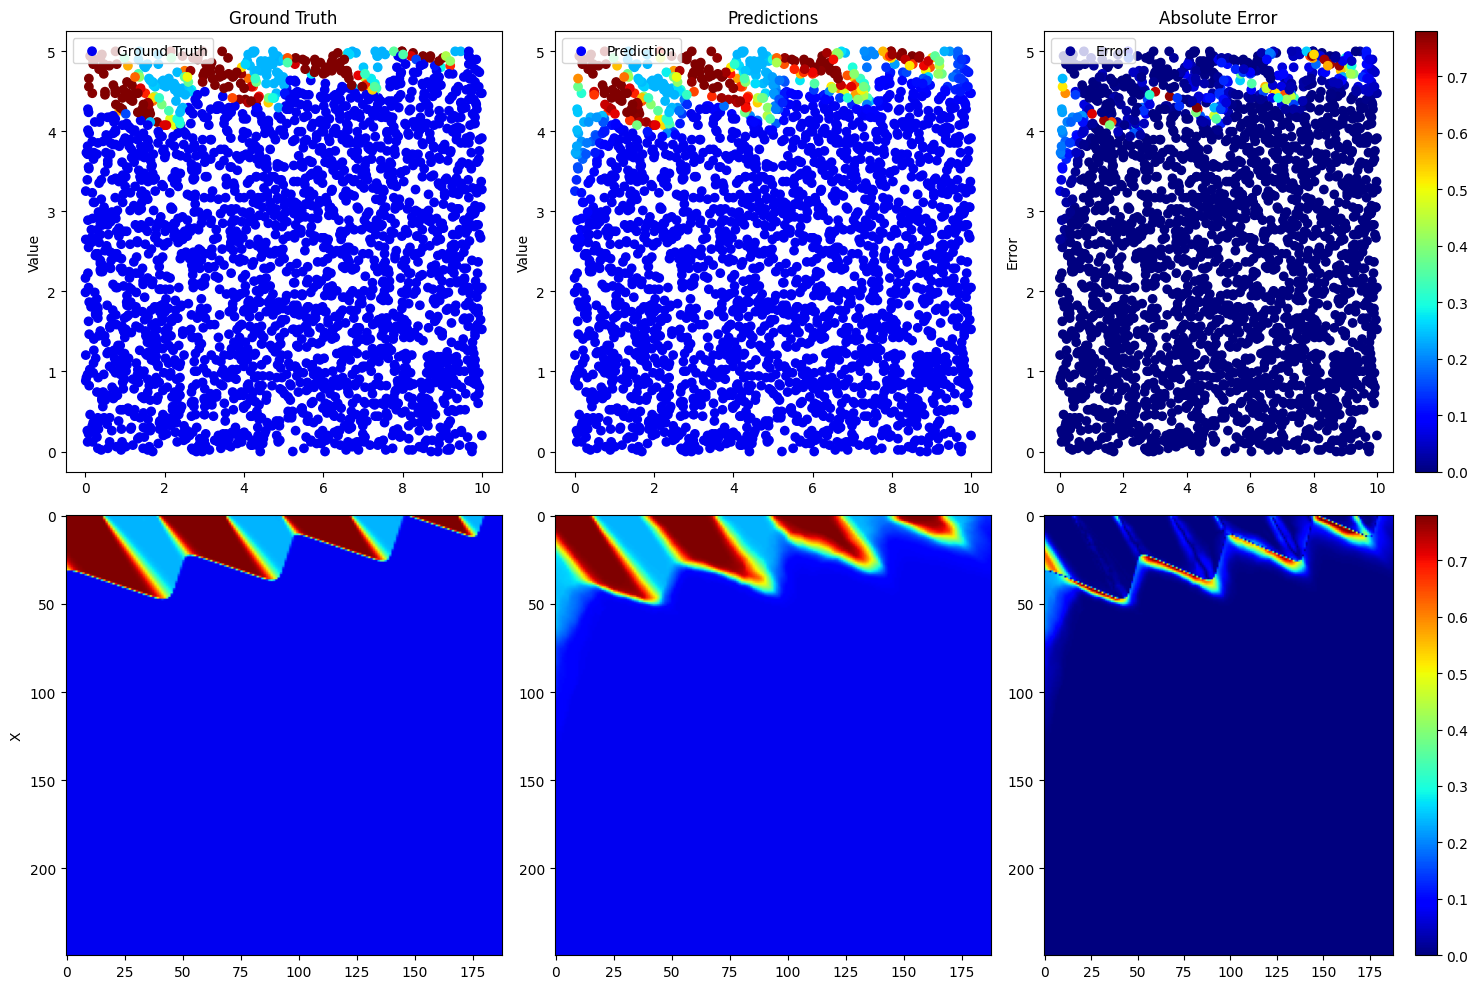

In [14]:
idx = 0


# Select the first sample in the batch for visualization
single_branch_coords = branch_coords[idx, :, :2].unsqueeze(0).to(device)  # Select relevant coordinates and add batch dimension
single_branch_values = branch_values[idx].unsqueeze(0).to(device)
single_trunk_coords = trunk_coords[idx].unsqueeze(0).to(device)
single_trunk_values = trunk_values[idx].unsqueeze(0)  # Bring ground truth to CPU for plotting

# Forward pass for a single realization
with torch.no_grad():
    with torch.cuda.amp.autocast():
        single_rho_pred, single_sigma = model(single_branch_coords, single_branch_values, single_trunk_coords)
        single_rho_pred = single_rho_pred.cpu()  # Bring prediction to CPU for plotting


# print shapes
print(f"single_branch_coords: {single_branch_coords.shape}, single_branch_values: {single_branch_values.shape}, single_trunk_coords: {single_trunk_coords.shape}, single_trunk_values: {single_trunk_values.shape}")
print(f"single_rho_pred: {single_rho_pred.shape}, single_sigma: {single_sigma.shape}")

# Plotting
plt.figure(figsize=(15, 10))  # Adjusted the figure size for better visibility

# Plot ground truth for the single realization
plt.subplot(2, 3, 1)
plt.scatter(single_trunk_coords[0,:,1].cpu().numpy(), single_trunk_coords[0,:,0].cpu().numpy(), c=single_trunk_values[0].cpu().numpy(), label='Ground Truth', cmap='jet', vmin=0, vmax=1)
plt.title("Ground Truth")
plt.ylabel("Value")
plt.legend()

# Plot predictions for the single realization
plt.subplot(2, 3, 2)
plt.scatter(single_trunk_coords[0,:,1].cpu().numpy(), single_trunk_coords[0,:,0].cpu().numpy(), c=single_rho_pred[:], label='Prediction', cmap='jet', vmin=0, vmax=1)
plt.title("Predictions")
plt.ylabel("Value")
plt.legend()

# Calculate and plot absolute error for the single realization
error = np.abs(single_rho_pred[:].cpu().numpy() - single_trunk_values[0].cpu().numpy())
plt.subplot(2, 3, 3)
plt.scatter(single_trunk_coords[0,:,1].cpu().numpy(), single_trunk_coords[0,:,0].cpu().numpy(), c=error, label='Error', cmap='jet', vmin=0, vmax=np.max(error))
plt.title("Absolute Error")
plt.colorbar()
plt.ylabel("Error")
plt.legend()

t_start = tstarts[idx].item()
start_index = np.where(t[0] == t_start)[0].item()
end_index = start_index + 188#np.where(t[0] >= t_pred)[0][0]
# end_index = start_index + 100
print(f"t_start: {t_start}")
print(f"start_index: {start_index}, end_index: {end_index}")
# t_end

# Plot 4 - Add another relevant visualization (as a placeholder)
plt.subplot(2, 3, 4)
plt.imshow(np.flipud(rhos[idx,:,start_index:end_index].cpu().numpy()), aspect='auto', cmap='jet', vmin=0, vmax=1)
plt.ylabel("X")

# create meshgrid for gridded inference results
x_ = torch.linspace(0, Xmax, Nx)
t_ = torch.linspace(0, t_pred+t_past, end_index-start_index)   
# grid_x, grid_y = torch.meshgrid(x_, t_[t_>=t_start]-t_start)
grid_x, grid_y = torch.meshgrid(x_, t_)
grid_coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).unsqueeze(0)  # Shape: [1, 10000, 2]
grid_coords = grid_coords.to(trunk_coords.device)
print(f"grid_coords: {grid_coords.shape}")

# Forward pass for gridded inference
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid_rho_pred, grid_sigma = model(single_branch_coords, single_branch_values, grid_coords)
        grid_rho_pred = grid_rho_pred.cpu().numpy().reshape(grid_x.shape)  # Bring prediction to CPU for plotting
        grid_sigma = np.exp(grid_sigma.cpu().numpy().reshape(grid_x.shape))



# Plot 5 - Add another relevant visualization (as a placeholder)
plt.subplot(2, 3, 5)
plt.imshow(np.flipud(grid_rho_pred), aspect='auto', cmap='jet', vmin=0, vmax=1)


plt.subplot(2, 3, 6)
plt.imshow(np.abs(np.flipud(grid_rho_pred)-np.flipud(rhos[idx,:,start_index:end_index].cpu().numpy())), aspect='auto', cmap='jet', vmin=0, vmax=np.max(error))
plt.colorbar()


mae = np.abs(np.flipud(grid_rho_pred)-np.flipud(rhos[idx,:,start_index:end_index].cpu().numpy()))
mse = np.square(np.flipud(grid_rho_pred)-np.flipud(rhos[idx,:,start_index:end_index].cpu().numpy()))
print(f"MAE: {100*np.mean(mae)}%")
print(f"MSE: {100*np.mean(mse)}%")


# Convert arrays to float32 before calculating the L2 norm
l2_error = np.linalg.norm(
    (grid_rho_pred - rhos[idx, :, start_index:end_index].cpu().numpy()).astype(np.float32), ord=2
)
l2_ground_truth = np.linalg.norm(
    rhos[idx, :, start_index:end_index].cpu().numpy().astype(np.float32), ord=2
)

# Calculate the relative L2 error
relative_l2_error = l2_error / l2_ground_truth

# Print the relative L2 error
print(f"Relative L2 Error: {relative_l2_error}")


# Compute the L1 norm of the error
l1_error = np.sum(np.abs(grid_rho_pred - rhos[idx, :, start_index:end_index].cpu().numpy()))

# Compute the L1 norm of the ground truth
l1_ground_truth = np.sum(np.abs(rhos[idx, :, start_index:end_index].cpu().numpy()))

# Calculate the relative L1 error
relative_l1_error = l1_error / l1_ground_truth

# Print the relative L1 error
print(f"Relative L1 Error: {relative_l1_error}")

plt.tight_layout()
plt.show()

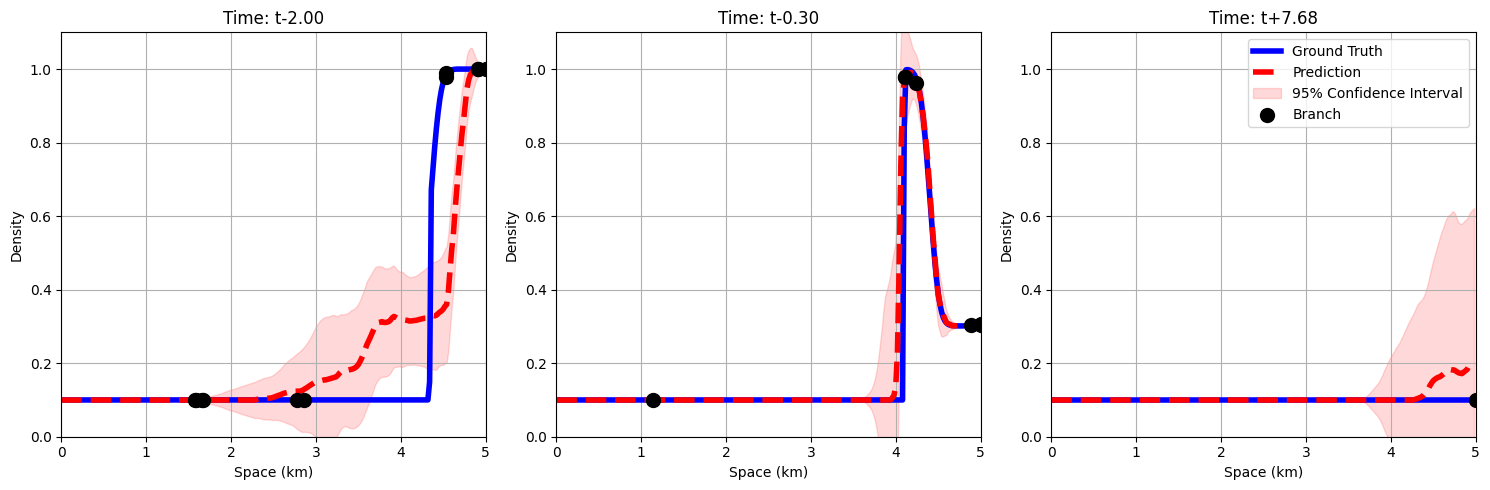

: 

In [15]:
# Define the mapping from step to time
def step_to_time(step):
    return -2 + (10 / 188) * step  # Linearly map step to time

# Define the mapping from space step to space in kilometers
def step_to_space(step):
    return (5 / 250) * step  # Linearly map step 0-250 to space 0-5 km

# Define three different time points
time_indices = [0, 32, 182]  # Example indices; adjust according to your data

plt.figure(figsize=(15, 5))  # Set the figure size for better visibility across three subplots

# Loop through each time index to plot ground truth, predictions, and uncertainty on separate subplots
for i, time_idx in enumerate(time_indices):
    plt.subplot(1, 3, i + 1)  # Define subplot position

    # Extracting predictions and their corresponding uncertainty
    predictions = grid_rho_pred[:, time_idx]
    sigma = grid_sigma[:, time_idx] 
    upper_bound = predictions + 2 * sigma  # 95% confidence interval
    lower_bound = predictions - 2 * sigma

    # Plot ground truth at the current time index
    plt.plot([step_to_space(x) for x in range(len(predictions))], 
             rhos[idx, :, start_index + time_idx].cpu().numpy(),
             label='Ground Truth',
             color='blue',
             linestyle='-',  # Solid line for ground truth
             linewidth=4,
             markersize=5)

    # Plot predictions at the current time index
    plt.plot([step_to_space(x) for x in range(len(predictions))], 
             predictions,
             label='Prediction',
             color='red',
             linestyle='--',  # Dashed line for predictions
             linewidth=4,
             markersize=5)

    # Plot the uncertainty band around the predictions
    plt.fill_between([step_to_space(x) for x in range(len(predictions))], 
                     lower_bound, upper_bound,
                     color='red', alpha=0.15, label='95% Confidence Interval')
    

    # Plot the scatter points and only add 'Branch' label once
    added_probe_label = False
    for coord, value in zip(branch_coords[idx], branch_values[idx]):
        if int(coord[1] * Nt / Tmax) == time_idx:
            # print(f"coord: {coord}, value: {value}, time_idx: {time_idx}")
            plt.scatter(coord[0].cpu().numpy(), value.cpu().numpy(), color='black', label='Branch' if not added_probe_label else None, s=100, zorder=2)

    # Calculate the actual time and use it in the title
    actual_time = step_to_time(time_idx)
    if actual_time < 0:
        plt.title(f"Time: t{actual_time:.2f}")
    else:
        plt.title(f"Time: t+{actual_time:.2f}")
    plt.xlabel("Space (km)")
    plt.ylabel("Density")
    plt.ylim(0, 1.1)
    plt.xlim(0, 5)  # Set x-axis limit to 0-5 km
    plt.grid(True)

plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()


# noise analysis

t_start: 4.53515625
start_index: 85, end_index: 273
grid_coords: torch.Size([1, 47000, 2])
Mean Absolute Error: 0.023495962843298912


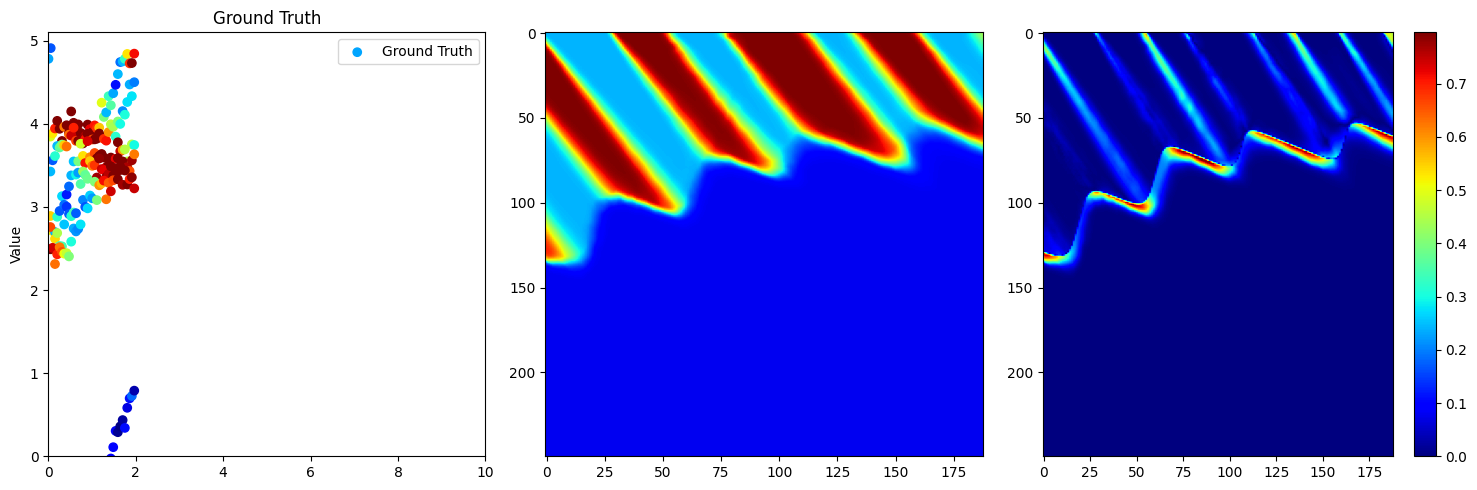

In [ ]:

idx = 0
single_branch_coords = branch_coords[idx, :, :].unsqueeze(0).to(device)
single_branch_values = branch_values[idx].unsqueeze(0).to(device)
single_trunk_coords = trunk_coords[idx].unsqueeze(0).to(device)
single_trunk_values = trunk_values[idx].unsqueeze(0)

# Make a copy of single_branch_coords to apply noise
noisy_branch_coords = single_branch_coords.clone()
noisy_branch_values = single_branch_values.clone()

noise_level_coords = 0.08  # Define the noise level for coordinates
noise_level_values = 0.08  # Define the noise level for values

# Apply noise only where the last index of branch_coords > 0
mask = branch_coords[idx, :, 2] > 0  # Create a mask for the condition
noise_coords = torch.zeros_like(noisy_branch_coords)  # Create a tensor of zeros with the same shape and dtype
noise_coords[0, mask, 0] = torch.randn(mask.sum(), dtype=noisy_branch_coords.dtype, device=noisy_branch_coords.device) * noise_level_coords
noisy_branch_coords[0, mask] += noise_coords[0, mask]  # Add noise only where the mask is True
noise_values = torch.randn_like(noisy_branch_values, dtype=noisy_branch_values.dtype) * noise_level_values
noisy_branch_values[0, mask] += noise_values[0, mask]  # Add noise only where the mask is True

# Use the mask to filter out only the active points for plotting
active_coords_x = noisy_branch_coords[0, mask, 1].cpu().numpy()
active_coords_y = noisy_branch_coords[0, mask, 0].cpu().numpy()
active_values = noisy_branch_values[0, mask].cpu().numpy()


plt.figure(figsize=(15, 5))  # Adjusted the figure size for better visibility

plt.subplot(1, 3, 1)
plt.scatter(active_coords_x, active_coords_y, c=active_values, label='Ground Truth', cmap='jet', vmin=0, vmax=1)
plt.title("Ground Truth")
plt.ylabel("Value")
plt.xlim(0, 10)
plt.ylim(0, 5.1)
plt.legend()


t_start = tstarts[idx].item()
start_index = np.where(t[0] == t_start)[0].item()
end_index = start_index + 188#np.where(t[0] >= t_pred)[0][0]
# end_index = start_index + 100
print(f"t_start: {t_start}")
print(f"start_index: {start_index}, end_index: {end_index}")
# t_end

# create meshgrid for gridded inference results
x_ = torch.linspace(0, Xmax, Nx)
t_ = torch.linspace(0, t_pred+t_past, end_index-start_index)   
# grid_x, grid_y = torch.meshgrid(x_, t_[t_>=t_start]-t_start)
grid_x, grid_y = torch.meshgrid(x_, t_)
grid_coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).unsqueeze(0)  # Shape: [1, 10000, 2]
grid_coords = grid_coords.to(trunk_coords.device)
print(f"grid_coords: {grid_coords.shape}")

# Forward pass for gridded inference
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid_rho_pred, grid_sigma = model(noisy_branch_coords[:,:,:2], noisy_branch_values, grid_coords)
        grid_rho_pred = grid_rho_pred.cpu().numpy().reshape(grid_x.shape)  # Bring prediction to CPU for plotting
        grid_sigma = np.exp(grid_sigma.cpu().numpy().reshape(grid_x.shape))



# Plot 5 - Add another relevant visualization (as a placeholder)
plt.subplot(1, 3, 2)
plt.imshow(np.flipud(grid_rho_pred), aspect='auto', cmap='jet', vmin=0, vmax=1)


plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.flipud(grid_rho_pred)-np.flipud(rhos[idx,:,start_index:end_index].cpu().numpy())), aspect='auto', cmap='jet', vmin=0, vmax=np.max(error))
plt.colorbar()

# print mean absolute error
print(f"Mean Absolute Error: {np.mean(error)}")

plt.tight_layout()
plt.show()

In [ ]:
# Function to evaluate the model with added noise
def evaluate_with_noise(noise_level_coords, noise_level_values):
    model.eval()
    FD.eval()

    losses = []  # Initialize for tracking loss
    mae_errors = []  # Initialize for tracking MAE
    mse_errors = []  # Initialize for tracking MSE per sample

    with torch.no_grad():
        for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in enumerate(val_loader_test):

            branch_coords = branch_coords.to(device)
            branch_values = branch_values.to(device)
            trunk_coords = trunk_coords.to(device)
            trunk_values = trunk_values.to(device)

            # Make a copy to apply noise
            noisy_branch_coords = branch_coords.clone()
            noisy_branch_values = branch_values.clone()

            # Apply noise where the last index of branch_coords > 0
            mask = branch_coords[:, :, 2] > 0
            noise_coords = torch.zeros_like(noisy_branch_coords)

            # Generate random noise with the correct shape
            noise = torch.randn(mask.sum(), 3, dtype=noisy_branch_coords.dtype, device=noisy_branch_coords.device) * noise_level_coords
            noise_coords[mask] = noise

            # Apply the noise
            noisy_branch_coords += noise_coords

            # Generate random noise for branch values
            noise_values = torch.randn_like(noisy_branch_values) * noise_level_values
            noisy_branch_values += noise_values

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                rho_pred, sigma = model(noisy_branch_coords[:, :, :2], noisy_branch_values, trunk_coords)
                
                # Calculate loss for the entire batch
                loss = criterion(rho_pred, trunk_values)
                losses.append(loss.item())

                # Calculate MAE and MSE per sample
                for idx in range(rho_pred.shape[0]):
                    mae = F.l1_loss(rho_pred[idx], trunk_values[idx], reduction='mean')
                    mse = F.mse_loss(rho_pred[idx], trunk_values[idx], reduction='mean')
                    mae_errors.append(mae.item())
                    mse_errors.append(mse.item())

    return mae_errors, mse_errors

# Define different noise levels to test
noise_levels_coord = np.linspace(0, 0.1, 10)
noise_levels_value = np.linspace(0, 0.1, 10)
mae_results = []
mse_results = []

# Evaluate the model for each noise level
for i in tqdm(range(len(noise_levels_coord))):
    mae, mse = evaluate_with_noise(noise_levels_coord[i], noise_levels_value[i])
    mae_results.append(mae)
    mse_results.append(mse)

# Create a boxplot for the MSE results
plt.figure(figsize=(8, 6))
plt.boxplot(mse_results, 
            vert=True, 
            patch_artist=True, 
            labels=[f"{nl:.2f}" for nl in noise_levels_coord],
            showfliers=False)

# Add titles and labels with improved font settings
plt.title("Boxplot of Mean Squared Errors (MSE) with Different Noise Levels", fontsize=12, fontweight='bold')
plt.xlabel("Noise Level", fontsize=10)
plt.ylabel("MSE", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add a light grid for clarity

plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


 20%|██        | 2/10 [00:32<02:10, 16.35s/it]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


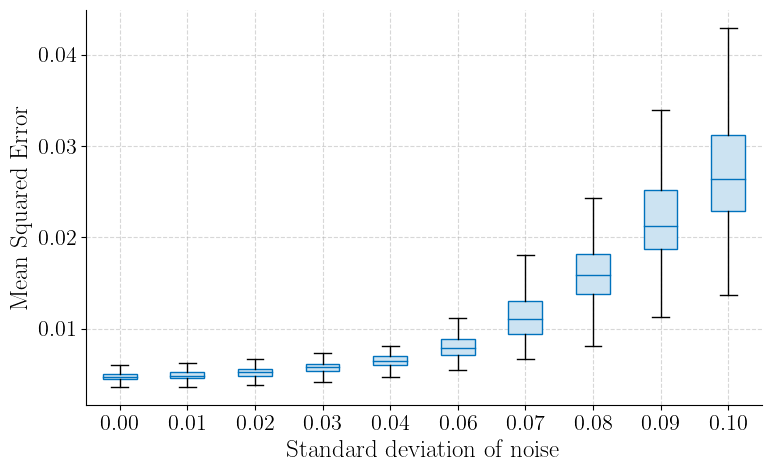

In [ ]:
plt.figure(figsize=(8, 5))

# Create the boxplot
box = plt.boxplot(mse_results, 
                  vert=True, 
                  patch_artist=True, 
                  labels=[f"{nl:.2f}" for nl in noise_levels_coord], 
                  showfliers=False)

# Customize boxplot colors
for b in box['boxes']:
    b.set(color='#0072bd', linewidth=1)  # Set outline color and line width
    b.set_facecolor('#cce3f2')  # Set inside color

# Keep whiskers and caps black
for whisker in box['whiskers']:
    whisker.set(color='black', linewidth=1)
for cap in box['caps']:
    cap.set(color='black', linewidth=1)

# Customize medians to match the outline color
for median in box['medians']:
    median.set(color='#0072bd', linewidth=1)

# Remove the upper and right axes edges
ax = plt.gca()  # Get the current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add titles and labels with LaTeX-style formatting
plt.xlabel(r"Standard deviation of noise", fontsize=18)  # LaTeX-style label
plt.ylabel(r"Mean Squared Error", fontsize=18)  # LaTeX-style label
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Horizontal grid
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Vertical grid

plt.tight_layout()  # Adjust layout to fit all labels

# Save the figure in .eps format
plt.savefig("generate_figures_data/noise_analysis_box.eps", format='eps')

plt.show()


# dropout analysis

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Jakee\AppData\Local\Temp\ipykernel_62652\2756235173.py:71: UserWarning: Using a target size (torch.Size([1, 4498])) that is different to the input size (torch.Size([4498])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(rho_pred, trunk_values[idx].unsqueeze(0), reduction='mean')  # Calculate MAE
C:\Users\Jakee\AppData\Local\Temp\ipykernel_62652\2756235173.py:72: UserWarning: Using a target size (torch.Size([1, 4498])) that is different to the input size (torch.Size([4498])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(rho_pred, trunk_values[idx].unsqueeze(0), reduction='mean')  # Calculate MAE


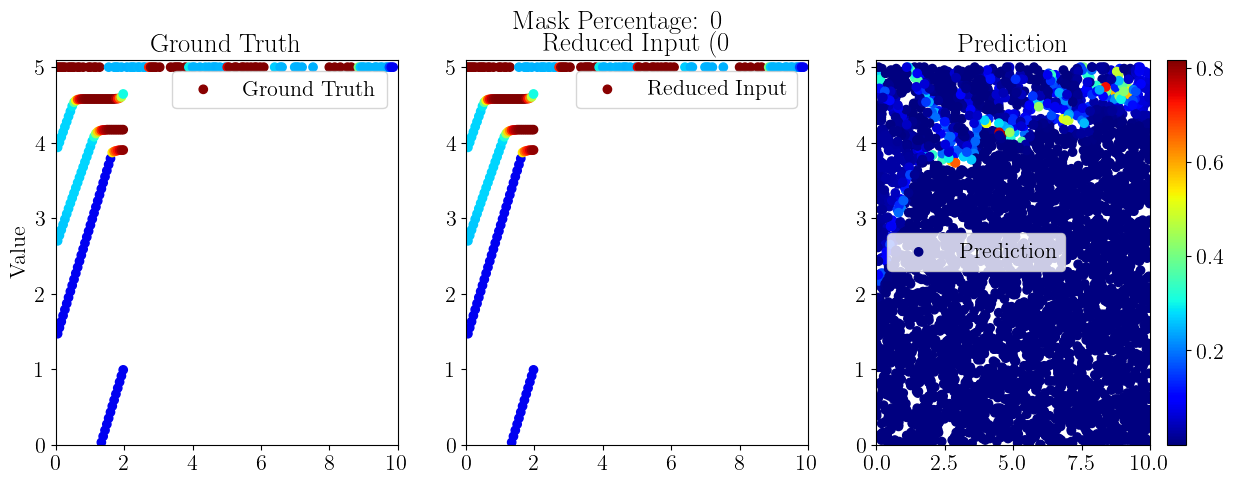

 50%|█████     | 1/2 [01:27<01:27, 87.72s/it]

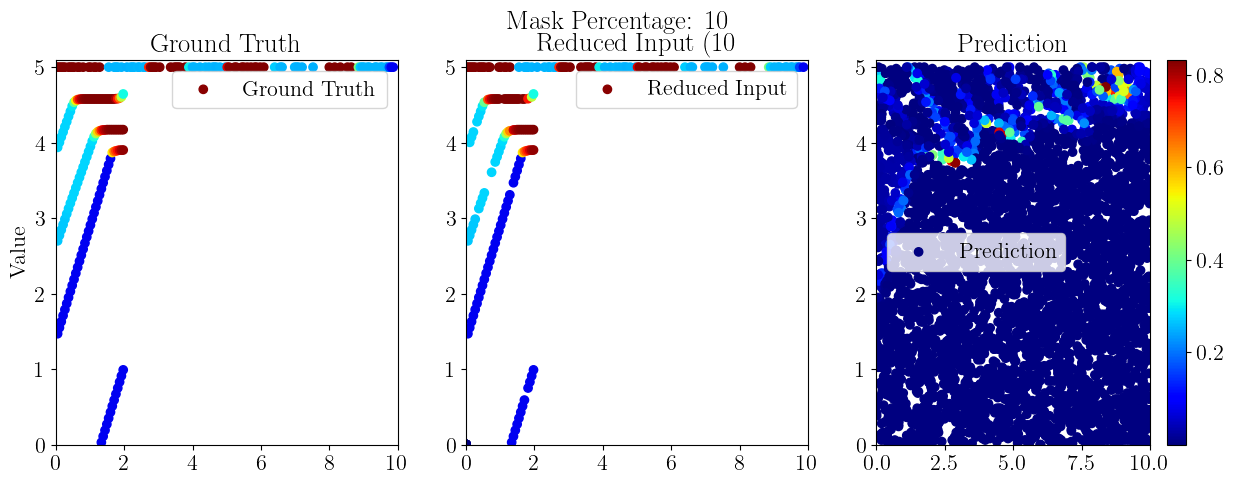

100%|██████████| 2/2 [03:01<00:00, 90.54s/it]


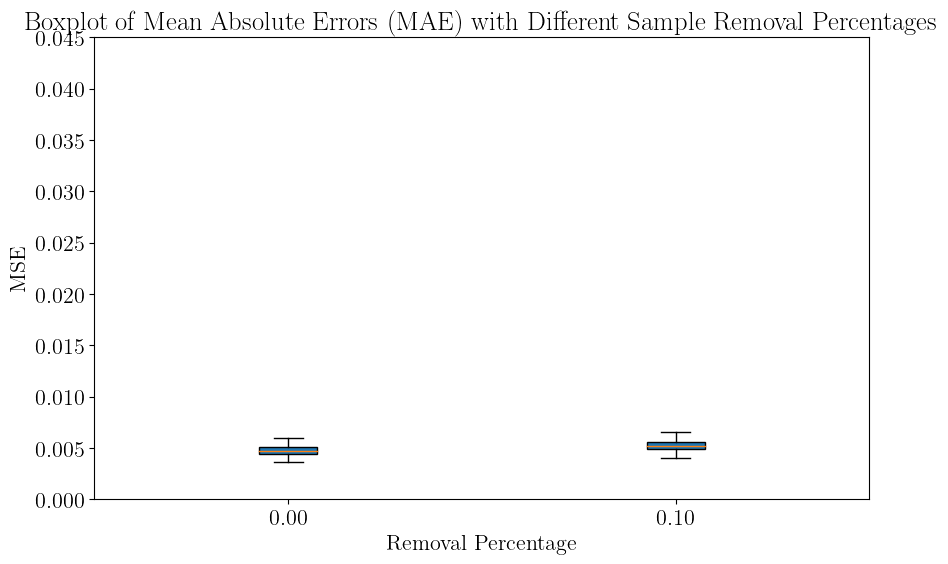

In [ ]:
# Function to evaluate the model with selective sample removal per sample and generate plots
def evaluate_with_mask_and_plot(mask_percentage):
    model.eval()
    FD.eval()

    losses = []  # Initialize for tracking loss
    mae_errors = []  # Initialize for tracking MAE
    mse_errors = []  # Initialize for tracking MSE

    with torch.no_grad():
        for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in enumerate(val_loader_test):

            mse_batch = []

            # if i == 50:
            #     break

            branch_coords = branch_coords.to(device)
            branch_values = branch_values.to(device)
            trunk_coords = trunk_coords.to(device)
            trunk_values = trunk_values.to(device)

            # Lists to store predictions and corresponding ground truth values
            all_rho_preds = []
            all_trunk_values = []

            # Apply mask and process each sample individually
            for idx in range(branch_coords.shape[0]):
                # Create a mask for the condition branch_coords[idx, :, 2] > 0
                mask = branch_coords[idx, :, 2] > -3  # Mask identifying eligible samples for this sample
                eligible_indices = torch.where(mask)[0]  # Collect indices where the mask is True
                num_eligible_samples = eligible_indices.size(0)
                num_to_remove = int(mask_percentage * num_eligible_samples)
                # print(num_to_remove)

                # Apply the mask to set the selected samples to zero for this sample
                if num_to_remove > 0 and num_eligible_samples > 0:
                    # Randomly select indices to mask out from eligible samples
                    remove_indices = eligible_indices[torch.randperm(num_eligible_samples)[:num_to_remove]]

                    # Create a mask to set the selected samples to zero
                    maskout_mask = torch.zeros(branch_coords.shape[1], dtype=torch.bool, device=branch_coords.device)
                    maskout_mask[remove_indices] = True

                    # Set the masked-out samples to zero
                    reduced_branch_coords = branch_coords[idx].clone()
                    reduced_branch_values = branch_values[idx].clone()
                    reduced_branch_coords[maskout_mask] = 0
                    reduced_branch_values[maskout_mask] = 0
                else:
                    # If no samples are to be masked out, keep the data as is
                    # print("No samples to mask out")
                    reduced_branch_coords = branch_coords[idx]
                    reduced_branch_values = branch_values[idx]

                # Forward pass for this sample
                with torch.cuda.amp.autocast():
                    rho_pred, sigma = model(
                        reduced_branch_coords[:, :2].unsqueeze(0),  # Add batch dimension
                        reduced_branch_values.unsqueeze(0),  # Add batch dimension
                        trunk_coords[idx].unsqueeze(0)  # Add batch dimension
                    )
                    sigma = torch.exp(sigma)  # Exponentiate sigma for variance
                    # print(f"rho_pred: {rho_pred.shape}, trunk_values: {trunk_values.shape}")

                all_rho_preds.append(rho_pred.squeeze(0))  # Remove batch dimension
                all_trunk_values.append(trunk_values[idx])

                # Calculate the loss for this sample
                loss = criterion(rho_pred, trunk_values[idx].unsqueeze(0))
                mae = F.l1_loss(rho_pred, trunk_values[idx].unsqueeze(0), reduction='mean')  # Calculate MAE
                mse = F.mse_loss(rho_pred, trunk_values[idx].unsqueeze(0), reduction='mean')  # Calculate MAE

                losses.append(loss.item())
                mae_errors.append(mae.item())
                
                mse_batch.append(mse.item())

                # Plotting the data for the first sample only
                if idx == 0 and i == 0:  # Only plot the first sample in the first batch
                    plt.figure(figsize=(15, 5))

                    # Ground Truth Plot
                    plt.subplot(1, 3, 1)
                    plt.scatter(
                        branch_coords[idx, :, 1].cpu().numpy(),
                        branch_coords[idx, :, 0].cpu().numpy(),
                        c=branch_values[idx].cpu().numpy(),
                        label='Ground Truth',
                        cmap='jet',
                        vmin=0,
                        vmax=1
                    )
                    plt.title("Ground Truth")
                    plt.ylabel("Value")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    # Reduced Input Plot
                    plt.subplot(1, 3, 2)
                    plt.scatter(
                        reduced_branch_coords[:, 1].cpu().numpy(),
                        reduced_branch_coords[:, 0].cpu().numpy(),
                        c=reduced_branch_values.cpu().numpy(),
                        label='Reduced Input',
                        cmap='jet',
                        vmin=0,
                        vmax=1
                    )
                    plt.title(f"Reduced Input ({mask_percentage * 100:.0f}% Removed)")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    # Prediction Plot
                    plt.subplot(1, 3, 3)
                    plt.scatter(
                        trunk_coords[idx, :, 1].cpu().numpy(),
                        trunk_coords[idx, :, 0].cpu().numpy(),
                        c=np.abs(rho_pred.squeeze(0).cpu().numpy() - trunk_values[0].squeeze(0).cpu().numpy()),
                        # c=sigma.squeeze(0).cpu().numpy(),
                        label='Prediction',
                        cmap='jet',
                        # vmin=0,
                        # vmax=0.3
                    )
                    plt.colorbar()
                    plt.title("Prediction")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    plt.suptitle(f"Mask Percentage: {mask_percentage * 100:.0f}%")
                    plt.show()

                # break  # Only process the first batch for plotting

            # Calculate the mean squared error for the batch
            mse_errors.append(np.mean(mse_batch))


    return mae_errors, mse_errors

# Define different mask percentages to test
mask_percentages = np.linspace(0, 0.1, 2)  # Mask percentages from 0% to 50%
mae_results = []
mse_results = []

# Evaluate the model for each mask percentage and generate plots
for mask_percentage in tqdm(mask_percentages):
    mae, mse = evaluate_with_mask_and_plot(mask_percentage)
    mae_results.append(mae)
    mse_results.append(mse)

# Generate a boxplot for different mask percentages
plt.figure(figsize=(10, 6))
plt.boxplot(mse_results, vert=True, patch_artist=True, labels=[f"{mp:.2f}" for mp in mask_percentages], showfliers=False)
plt.title("Boxplot of Mean Absolute Errors (MAE) with Different Sample Removal Percentages")
plt.xlabel("Removal Percentage")
plt.ylabel("MSE")
plt.ylim(0, 0.045)
plt.show()


# masking time

  0%|          | 0/10 [00:00<?, ?it/s]

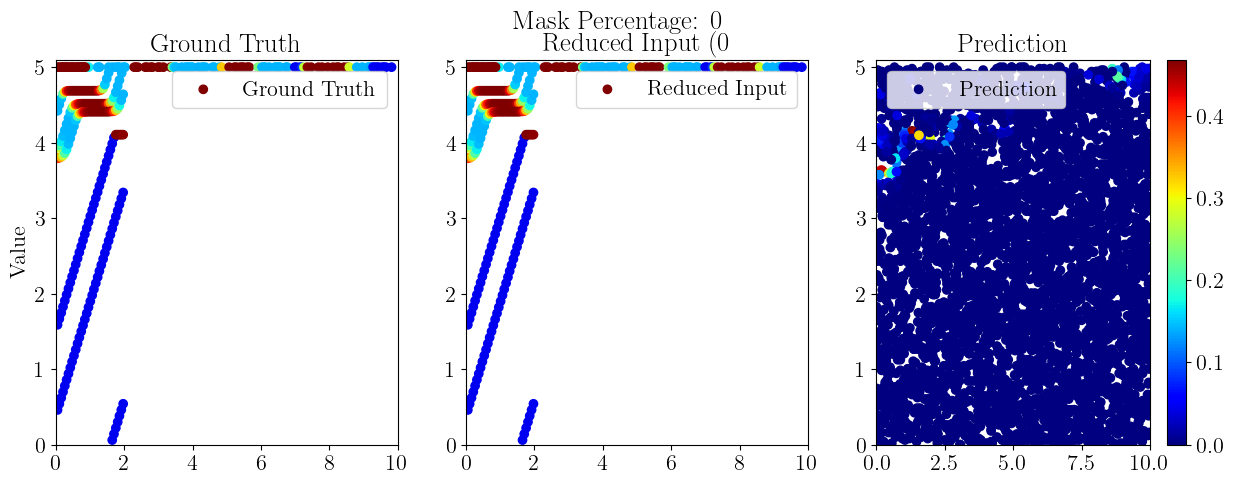

 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

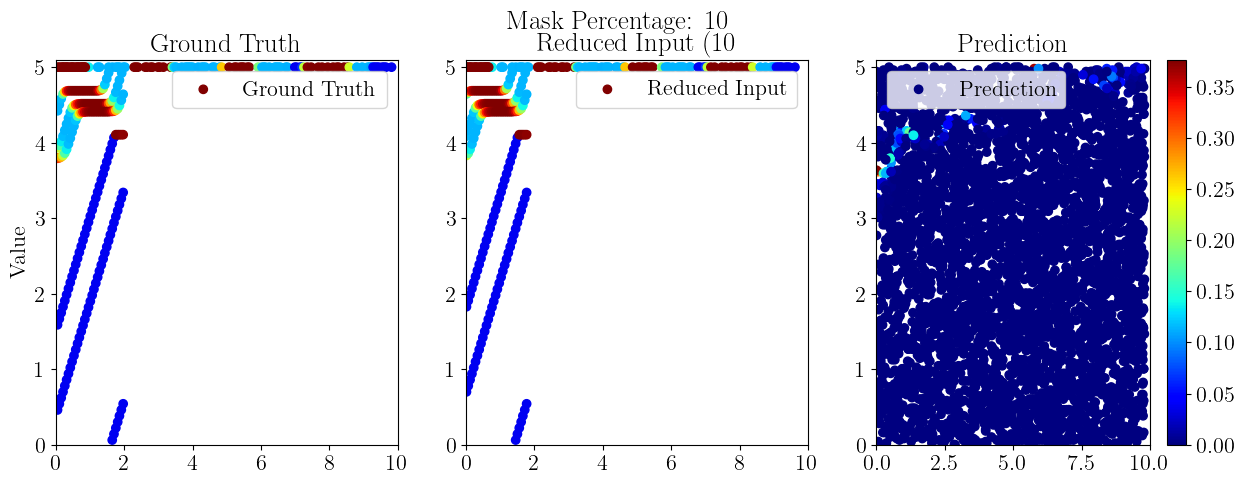

 20%|██        | 2/10 [00:08<00:36,  4.54s/it]

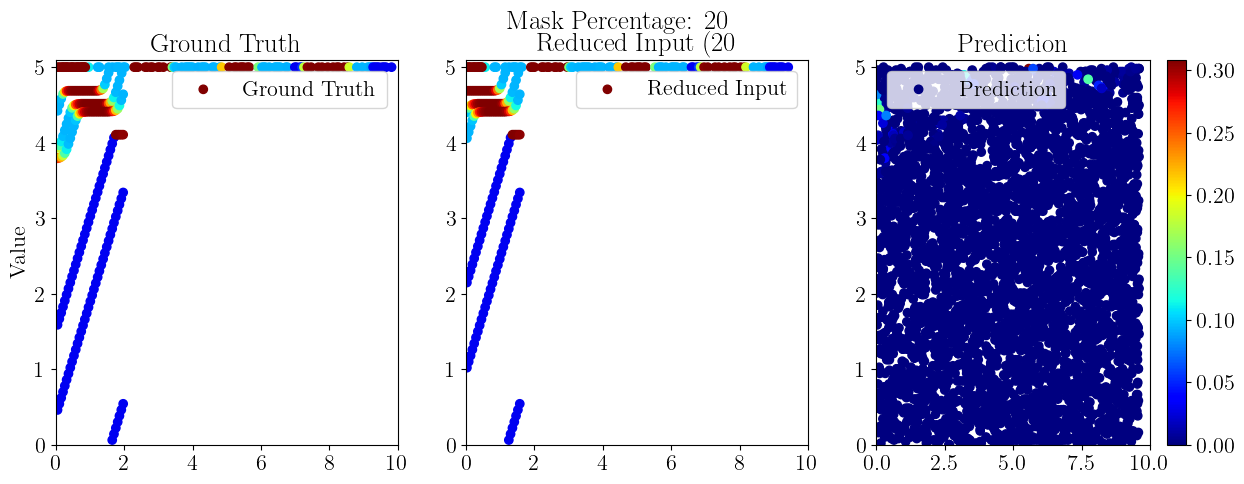

 30%|███       | 3/10 [00:14<00:36,  5.18s/it]

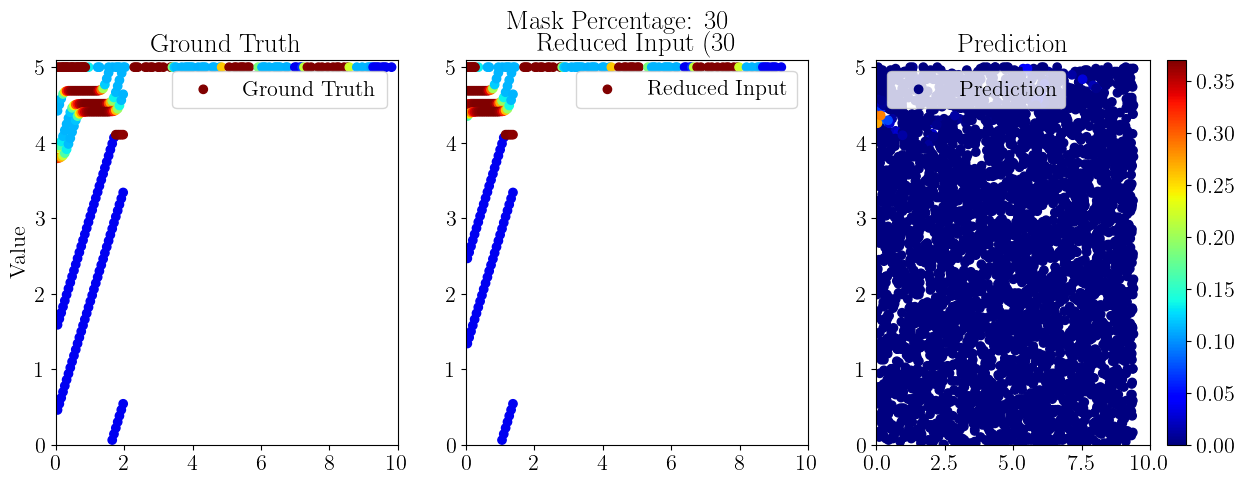

 40%|████      | 4/10 [00:20<00:32,  5.39s/it]

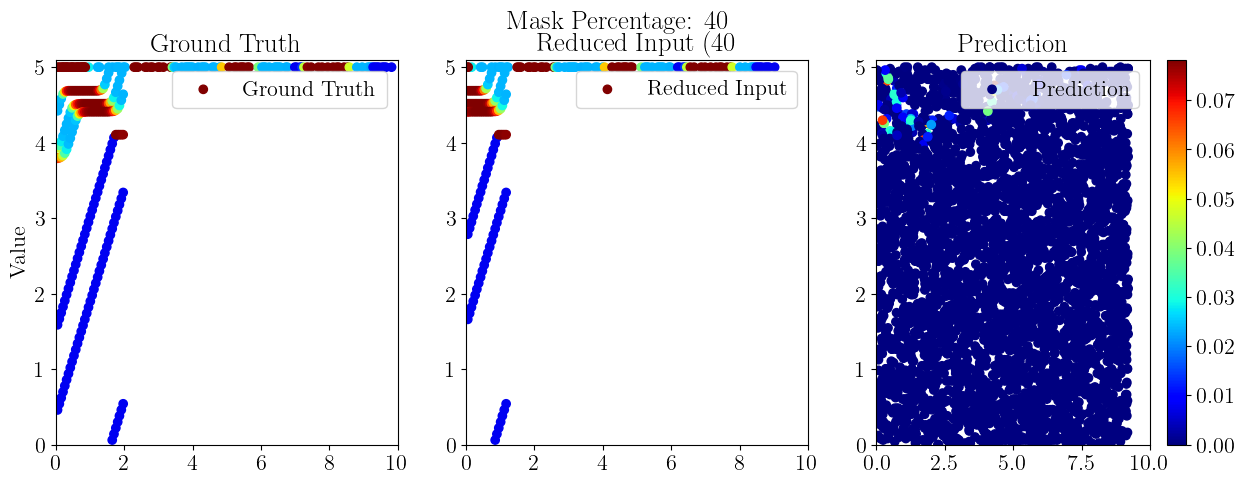

 50%|█████     | 5/10 [00:26<00:28,  5.69s/it]

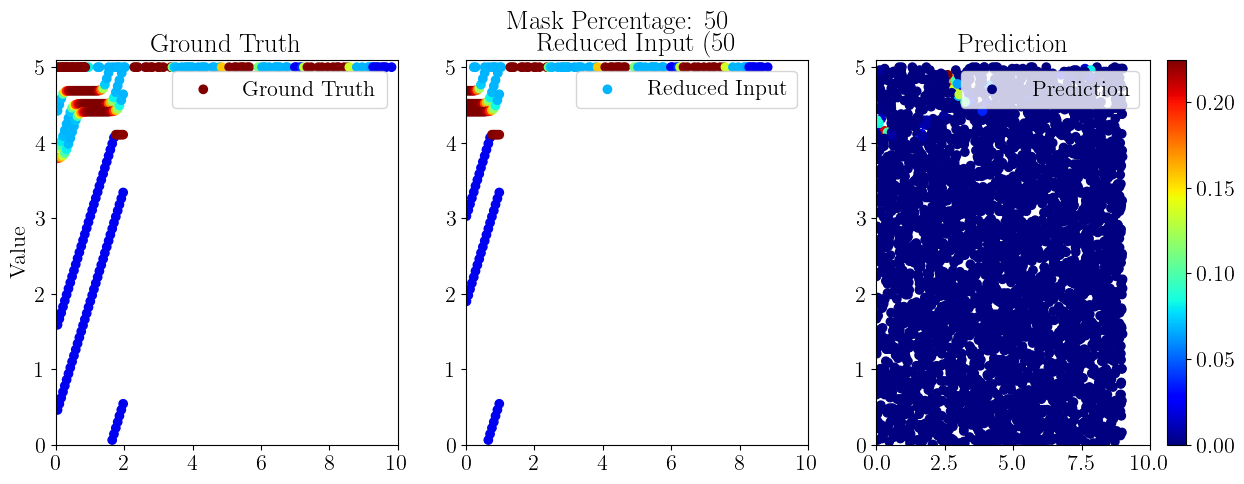

 60%|██████    | 6/10 [00:32<00:22,  5.72s/it]

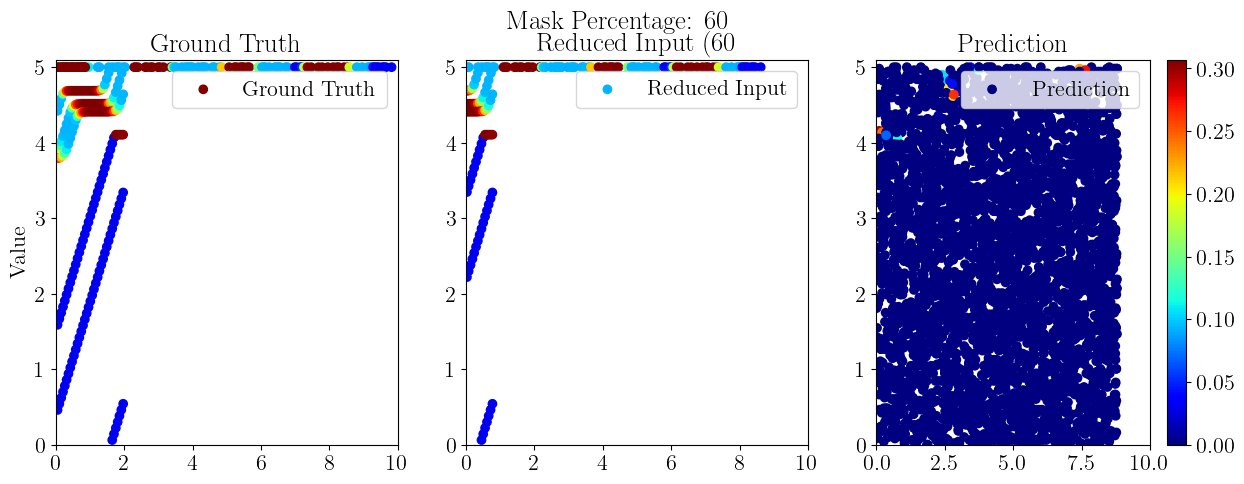

 70%|███████   | 7/10 [00:37<00:17,  5.68s/it]

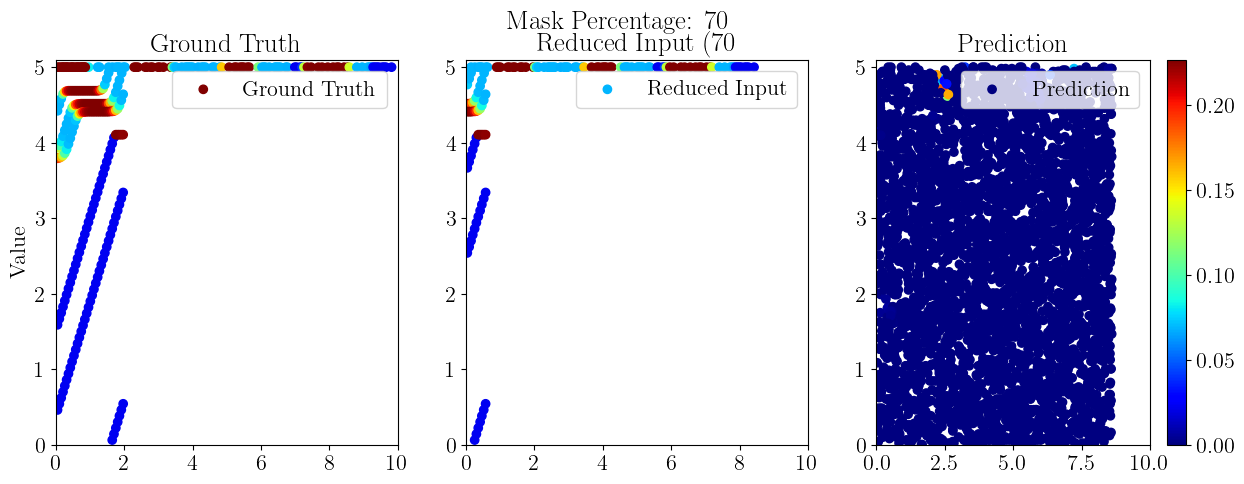

 80%|████████  | 8/10 [00:43<00:11,  5.67s/it]

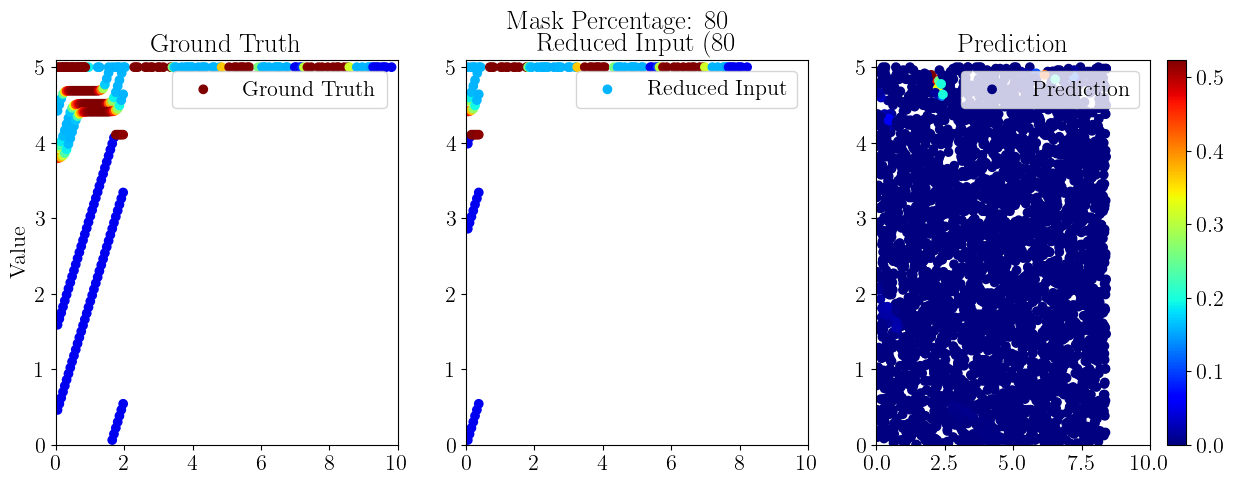

 90%|█████████ | 9/10 [00:49<00:05,  5.72s/it]

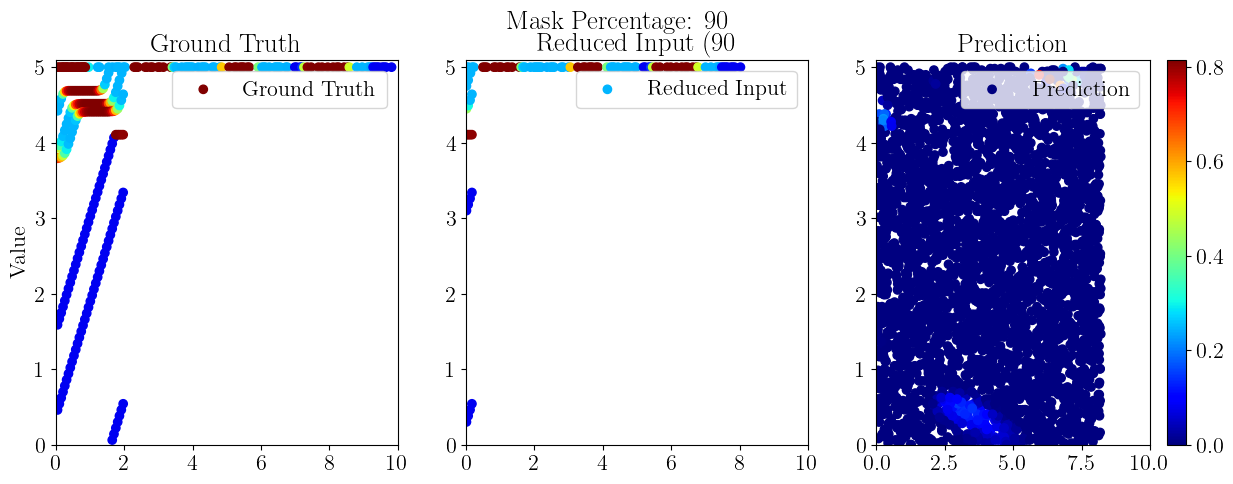

100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


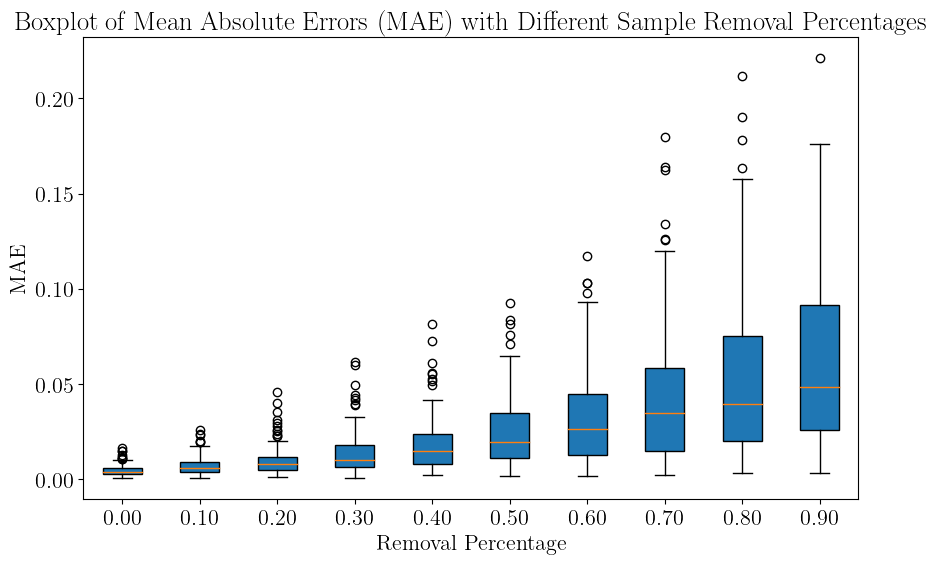

In [ ]:
# Function to evaluate the model with selective sample removal per sample and generate plots
def evaluate_with_mask_and_plot(mask_percentage):
    model.eval()
    FD.eval()

    losses = []  # Initialize for tracking loss
    mae_errors = []  # Initialize for tracking MAE

    with torch.no_grad():
        for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in enumerate(val_loader_test):

            branch_coords = branch_coords.to(device)
            branch_values = branch_values.to(device)
            trunk_coords = trunk_coords.to(device)
            trunk_values = trunk_values.to(device)

            # Lists to store predictions and corresponding ground truth values
            all_rho_preds = []
            all_trunk_values = []

            if i == 5:
                break

            # Apply mask and process each sample individually
            for idx in range(branch_coords.shape[0]):
                # Create a mask for the condition branch_coords[idx, :, 2] > 0
                mask = branch_coords[idx, :, 2] > -1  # Mask identifying eligible samples for this sample
                eligible_indices = torch.where(mask)[0]  # Collect indices where the mask is True
                num_eligible_samples = eligible_indices.size(0)
                num_to_remove = int(mask_percentage * num_eligible_samples)

                # Apply the filter based on the time of the coordinates with id > 0 and keep all id == -1
                if num_to_remove > 0 and num_eligible_samples > 0:
                    # Identify coordinates with id > 0
                    id_positive_mask = branch_coords[idx, :, 2] > 0  # Mask for coordinates with id > 0
                    time_values = branch_coords[idx, :, 1]  # Assuming the time is stored in the first dimension

                    a = mask_percentage * 2  # Mask up to 'a' as a fraction of the maximum time value

                    # Create a filter to keep only coordinates with time in the range [a, max] for id > 0
                    time_filter = (time_values > a) & (time_values <= max(time_values))
                    combined_mask = id_positive_mask & time_filter  # Apply the time filter only to coordinates with id > 0

                    # Remove coordinates with id == -1 that are before 'a'
                    id_negative_mask = (branch_coords[idx, :, 2] == -1) & (time_values > a)

                    # Create the final mask to keep only the selected samples
                    final_mask = id_negative_mask | combined_mask

                    # Apply the final mask to keep only the selected samples
                    reduced_branch_coords = branch_coords[idx, final_mask, :].clone()
                    reduced_branch_values = branch_values[idx, final_mask].clone()

                    # Shift the time values of reduced_branch_coords back by 'a' to align them with zero
                    reduced_branch_coords[:, 1] -= a

                    # Apply the same shift and mask to trunk_coords and trunk_values
                    trunk_time_mask = (trunk_coords[idx, :, 1] > a)  # Mask based on the same time shift 'a'
                    shifted_trunk_coords = trunk_coords[idx, trunk_time_mask, :].clone()
                    shifted_trunk_coords[:, 1] -= a  # Shift time values back by 'a'
                    shifted_trunk_values = trunk_values[idx, trunk_time_mask].clone()  # Mask and align trunk_values
                else:
                    # If no samples are to be masked out, keep the data as is
                    reduced_branch_coords = branch_coords[idx]
                    reduced_branch_values = branch_values[idx]
                    shifted_trunk_coords = trunk_coords[idx]
                    shifted_trunk_values = trunk_values[idx]

               # Check and reshape rho_pred and shifted_trunk_values to ensure they have the same shape
                with torch.cuda.amp.autocast():
                    rho_pred, sigma = model(
                        reduced_branch_coords[:, :2].unsqueeze(0),  # Add batch dimension
                        reduced_branch_values.unsqueeze(0),  # Add batch dimension
                        shifted_trunk_coords.unsqueeze(0)  # Add batch dimension
                    )

                if rho_pred.shape != shifted_trunk_values.shape:
                    shifted_trunk_values = shifted_trunk_values.squeeze(0)  # Remove the extra batch dimension

                # Now calculate the loss
                loss = criterion(rho_pred, shifted_trunk_values)
                mae = F.l1_loss(rho_pred, shifted_trunk_values, reduction='mean')  # Calculate MAE

                losses.append(loss.item())
                mae_errors.append(mae.item())

                # Plotting the data for the first sample only
                if idx == 0 and i == 0:  # Only plot the first sample in the first batch
                    plt.figure(figsize=(15, 5))

                    # Ground Truth Plot
                    plt.subplot(1, 3, 1)
                    plt.scatter(
                        branch_coords[idx, :, 1].cpu().numpy(),
                        branch_coords[idx, :, 0].cpu().numpy(),
                        c=branch_values[idx].cpu().numpy(),
                        label='Ground Truth',
                        cmap='jet',
                        vmin=0,
                        vmax=1
                    )
                    plt.title("Ground Truth")
                    plt.ylabel("Value")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    # Reduced Input Plot
                    plt.subplot(1, 3, 2)
                    plt.scatter(
                        reduced_branch_coords[:, 1].cpu().numpy(),
                        reduced_branch_coords[:, 0].cpu().numpy(),
                        c=reduced_branch_values.cpu().numpy(),
                        label='Reduced Input',
                        cmap='jet',
                        vmin=0,
                        vmax=1
                    )
                    plt.title(f"Reduced Input ({mask_percentage * 100:.0f}% Removed)")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    # Prediction Plot
                    plt.subplot(1, 3, 3)
                    plt.scatter(
                        shifted_trunk_coords[:, 1].cpu().numpy(),
                        shifted_trunk_coords[:, 0].cpu().numpy(),
                        c=rho_pred.squeeze(0).cpu().numpy() - shifted_trunk_values.squeeze(0).cpu().numpy(),
                        label='Prediction',
                        cmap='jet',
                        vmin=0,
                        # vmax=1
                    )
                    plt.colorbar()
                    plt.title("Prediction")
                    plt.xlim(0, 10)
                    plt.ylim(0, 5.1)
                    plt.legend()

                    plt.suptitle(f"Mask Percentage: {mask_percentage * 100:.0f}%")
                    plt.show()

                # break  # Only process the first batch for plotting

    return mae_errors, losses



# Define different mask percentages to test
mask_percentages = np.linspace(0, 0.9, 10)  # Mask percentages from 0% to 50%
mae_results = []
mse_results = []

# Evaluate the model for each mask percentage and generate plots
for mask_percentage in tqdm(mask_percentages):
    mae, mse = evaluate_with_mask_and_plot(mask_percentage)
    mae_results.append(mae)
    mse_results.append(mse)

# Generate a boxplot for different mask percentages
plt.figure(figsize=(10, 6))
plt.boxplot(mse_results, vert=True, patch_artist=True, labels=[f"{mp:.2f}" for mp in mask_percentages])
plt.title("Boxplot of Mean Absolute Errors (MAE) with Different Sample Removal Percentages")
plt.xlabel("Removal Percentage")
plt.ylabel("MAE")
plt.show()


# uncertainty quantification analysis

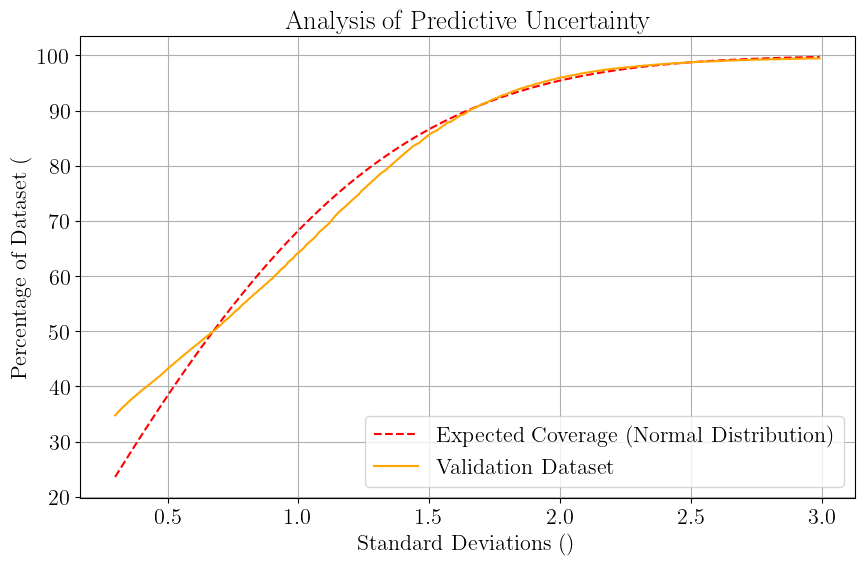

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define the range of standard deviations to evaluate coverage for
std_multiples = np.arange(0.3, 3, 0.01)  # From 0.5σ to 3.0σ in steps of 0.5
percent_coverage = []

with torch.no_grad():
    # Take just one batch from the validation loader
    for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in enumerate(val_loader_test):
        branch_coords = branch_coords.to(device)
        branch_values = branch_values.to(device)
        trunk_coords = trunk_coords.to(device)
        trunk_values = trunk_values.to(device)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            rho_pred, sigma = model(branch_coords[:, :, :2], branch_values, trunk_coords)
            sigma = torch.exp(sigma)  # Convert log(std) to std

        # Calculate the raw errors for the batch
        batch_error = (rho_pred - trunk_values).abs()  # Absolute error

        # Convert tensors to numpy arrays
        predicted_means = rho_pred.cpu().numpy().flatten()
        uncertainties = sigma.cpu().numpy().flatten()
        true_values = trunk_values.cpu().numpy().flatten()

        # Break after processing the first batch to avoid too much data
        # if i > 100:
        #     break

# Calculate coverage for different multiples of standard deviation
for x in std_multiples:
    # Define the lower and upper bounds for the prediction interval
    lower_bound = predicted_means - x * uncertainties
    upper_bound = predicted_means + x * uncertainties

    # Check if the true values fall within the bounds
    in_interval = (true_values >= lower_bound) & (true_values <= upper_bound)

    # Calculate the percentage of points within the interval
    coverage = np.mean(in_interval) * 100  # Convert to percentage
    percent_coverage.append(coverage)

# Calculate the expected normal distribution coverage for each multiple of standard deviation
expected_coverage = [100 * (norm.cdf(x) - norm.cdf(-x)) for x in std_multiples]

# Plot the coverage analysis
plt.figure(figsize=(10, 6))
plt.plot(std_multiples, expected_coverage, linestyle='--', color='red', label='Expected Coverage (Normal Distribution)')
plt.plot(std_multiples, percent_coverage, linestyle='-', color='orange', label='Validation Dataset')

plt.xlabel('Standard Deviations ()')
plt.ylabel('Percentage of Dataset (%)')
plt.title('Analysis of Predictive Uncertainty')
plt.legend()
plt.grid(True)
# plt.ylim(40, 100)
plt.show()



In [ ]:
# Validate model on validation set
model.eval()
FD.eval()
import torch.nn.functional as F

losses = []  # Initialize for tracking MSE
mae_errors = []  # Initialize for tracking MAE
relative_l2_errors = []  # Initialize for tracking relative L2 loss
relative_l1_errors = []  # Initialize for tracking relative L1 loss

model.load_state_dict(torch.load("model_irregular_boundary_UQTrue_random_sampling_18_nov_p400.pth"))

with torch.no_grad():
    for i, (branch_coords, branch_values, trunk_coords, trunk_values, rhos, tstarts) in tqdm(enumerate(val_loader_test)):
        branch_coords = branch_coords.to(device)
        branch_values = branch_values.to(device)
        trunk_coords = trunk_coords.to(device)
        trunk_values = trunk_values.to(device)
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            rho_pred, sigma = model(branch_coords[:,:,:2], branch_values, trunk_coords)
            
            # Calculate per-sample MSE and MAE
            mse_per_sample = F.mse_loss(rho_pred, trunk_values, reduction='none').mean(dim=1)  # MSE per sample
            mae_per_sample = F.l1_loss(rho_pred, trunk_values, reduction='none').mean(dim=1)  # MAE per sample
            
            # Calculate per-sample relative L2 and L1 errors
            ground_truth_squared = (trunk_values ** 2).mean(dim=1)  # Mean squared ground truth values per sample
            ground_truth_abs = trunk_values.abs().mean(dim=1)  # Mean absolute ground truth values per sample

            relative_l2_per_sample = torch.sqrt(mse_per_sample / ground_truth_squared)  # Relative L2 loss
            relative_l1_per_sample = mae_per_sample / ground_truth_abs  # Relative L1 loss

        # Collect each sample's errors
        losses.extend(mse_per_sample.cpu().numpy())
        mae_errors.extend(mae_per_sample.cpu().numpy())
        relative_l2_errors.extend(relative_l2_per_sample.cpu().numpy())
        relative_l1_errors.extend(relative_l1_per_sample.cpu().numpy())

# Calculate mean of the per-sample losses and errors
validation_loss = np.mean(losses)
mean_absolute_error = np.mean(mae_errors)
mean_relative_l2_error = np.mean(relative_l2_errors)
mean_relative_l1_error = np.mean(relative_l1_errors)

print(f"Validation loss (per sample): {validation_loss}")
print(f"Mean Absolute Error (MAE) per sample: {mean_absolute_error}")
print(f"Mean Relative L2 Error: {mean_relative_l2_error*100}")
print(f"Mean Relative L1 Error: {mean_relative_l1_error*100}")


250it [00:06, 40.95it/s]

Validation loss (per sample): 0.005942053627222776
Mean Absolute Error (MAE) per sample: 0.02707708068192005
Mean Relative L2 Error: 17.25849360227585
Mean Relative L1 Error: 8.170197904109955
